<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/HAFSA_ocean-atmosphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up environment

In [ ]:
!pip install cfgrib

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import cfgrib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#User parameters

In [ ]:
name = "Milton"
tcNum = "14"
trackType = ""

centralTime = dt(year=2024, month=10, day=7, hour=6) #Time when Milton began its most rapid intensification
daysBefore = 0 #Days before the focal point
daysAfter = 0 #Days after focal point

fHourStep = 3       #Normally 3 for HAFS-A
forecastLength = 54 #Normally 126 for HAFS-A.
runStep = 6         #Normally 6 for HAFS-A

figureSuffix = "_RI"
subfolder = "RI/"
dataPath = "/content/drive/MyDrive/savedData/"
figurePath = "/content/drive/MyDrive/figures/"

stormCentered = True
if stormCentered: figureSuffix += "_SC"

potentialTemp = True #Use atmospheric potential temperature instead of in-situ temperature

atmTop = 850
oceFloor = 100

Get ATCF data and find interested point

#Retrieve HAFS-A Data

In [ ]:
dateFormat = "%Y-%m-%d %H:%M:%S"
runFormat = "%Y%m%d%H"

start = centralTime - pd.Timedelta(days=daysBefore)
end = centralTime + pd.Timedelta(days=daysAfter)

Find times needed

In [ ]:
fcastTimes = {} #Key: initiation, item: valid time list

initTime = start
while initTime <= end:
  validTime = initTime
  fcastTimes[initTime] = []
  fhour = 0

  while fhour <= forecastLength:
    fcastTimes[initTime].append(validTime)
    validTime += pd.Timedelta(hours=fHourStep)
    fhour += fHourStep

  initTime += pd.Timedelta(hours=runStep)

Find storm location in HAFS-A from ATCF files. Used to find along-storm profile.

In [ ]:
cols = ["BASIN", "CY", "YYYYMMDDHH", "TECHNUM/MIN", "TECH", "TAU", "LatN/S", "LonE/W",
    "VMAX", "MSLP", "TY", "RAD", "WINDCODE", "RAD1", "RAD2", "RAD3", "RAD4",
    "POUTER", "ROUTER", "RMW", "GUSTS", "EYE", "SUBREGION", "MAXSEAS", "INITIALS",
    "DIR", "SPEED", "STORMNAME", "DEPTH", "SEAS", "SEASCODE", "SEAS1", "SEAS2",
    "SEAS3", "SEAS4", "USERDEFINED1", "Thermo1", "Thermo2", "Thermo3", "Thermo4",
    "Thermo5", "Thermo6", "Thermo7", "USERDEFINED2", "DT", "SHR82", "SHR81_1",
    "SHR82_2",  "USERDEFINED3", "SST", "USERDEFINED4", "ARMW1", "ARMW2"]

In [ ]:
if not stormCentered:

  ctStr = centralTime.strftime("%Y%m%d")
  ctHour = centralTime.strftime("%H")

  atcfURL = f"https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/{ctStr}/{ctHour}/{tcNum}l.{ctStr}{ctHour}.hfsa.trak.atcfunix"
  atcfFile = "atcf_" + ctStr + "_" + ctHour + ".csv"

  !wget -O {atcfFile} {atcfURL}
  atcf = pd.read_csv(atcfFile, names=cols)

  pointLat = int(atcf[atcf.TAU==0]["LatN/S"].iloc[0].replace("N", ""))/10
  pointLon = int(atcf[atcf.TAU==0]["LonE/W"].iloc[0].replace("W", ""))/-10 #Assume western hemisphere

  point = (pointLat, pointLon)
  point

In [ ]:
if stormCentered:
  tcLocs = {}

  for init, validList in fcastTimes.items():
    tcLocs[init] = {}
    initStr, initHour = init.strftime("%Y%m%d_%H").split("_")

    atcfURL = f"https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/{initStr}/{initHour}/{tcNum}l.{initStr}{initHour}.hfsa.trak.atcfunix"
    atcfFile = "atcf_" + initStr + "_" + initHour + ".csv"

    !wget -O {atcfFile} {atcfURL}
    atcf = pd.read_csv(atcfFile, names=cols)

    for valid in validList:
      fHour = int((valid-init).total_seconds() / 3600)

      pointLat = int(atcf[atcf.TAU==fHour]["LatN/S"].iloc[0].replace("N", ""))/10
      pointLon = int(atcf[atcf.TAU==fHour]["LonE/W"].iloc[0].replace("W", ""))/-10 #Assume western hemisphere
      tcLocs[init][valid] = (pointLat, pointLon)

Get data from HAFS-A output.

In [ ]:
atm = {}

for init, validList in fcastTimes.items():

  atm[init] = {}
  initTime = init.strftime("%Y%m%d%H")

  for valid in validList:
    atm[init][valid] = {}

    fhour = str(int((valid-init).total_seconds() / 3600))
    while len(fhour) < 3: fhour = "0" + fhour

    atmFile = "hafsa_" + initTime + "_f" + fhour + ".nc"
    atmPath = dataPath + "hafsaOutput/" + subfolder + atmFile
    atmData = xr.open_dataset(atmPath)

    if stormCentered: point = tcLocs[init][valid]

    atmLayers = atmData.isobaricInhPa.data[atmData.isobaricInhPa.data>=atmTop]
    for layer in atmLayers:
      #Longitude in atm files are in degrees east, but are -180 - 180 in oce files. point has them from -180 - 180
      validPoint = atmData.sel(latitude=point[0], longitude=point[1] + 360, isobaricInhPa=layer, method="nearest")

      atm[init][valid][layer] = {}
      atm[init][valid][layer]["T"] = float(validPoint.t.data)
      if potentialTemp: atm[init][valid][layer]["T"] = float(validPoint.t.data)*((1000/layer)**0.28571) #Formula from Stull R. 2017
      atm[init][valid][layer]["q"] = float(validPoint.q.data) * 1000 #Convert from kg/kg to g/kg
      atm[init][valid][layer]["u"] = float(validPoint.u.data)
      atm[init][valid][layer]["v"] = float(validPoint.v.data)
      atm[init][valid][layer]["gh"] = float(validPoint.gh.data)

In [ ]:
oce = {}

for init, validList in fcastTimes.items():

  oce[init] = {}
  initTime = init.strftime("%Y%m%d%H")

  for valid in validList:
    oce[init][valid] = {}

    fhour = str(int((valid-init).total_seconds() / 3600))
    while len(fhour) < 3: fhour = "0" + fhour
    oceFile = "mom6_" + initTime + "_f" + fhour + ".nc"
    ocePath = dataPath + "mom6Output/" + subfolder + oceFile

    if oceFile == 'mom6_2024100800_f000.nc': #This file is missing
      for layer in oceData.z_l.data:
        oce[init][valid][layer] = {"T":np.nan, "s":np.nan, "u":np.nan, "v":np.nan}
      continue

    oceData = xr.open_dataset(ocePath, decode_times=False)

    if stormCentered: point = tcLocs[init][valid]

    oceLayers = oceData.z_l.data[oceData.z_l.data<=oceFloor]
    for layer in oceLayers:
      oce[init][valid][layer] = {}
      oce[init][valid][layer]["T"] = float(oceData.sel(yq=point[0], yh=point[0], xh=point[1], xq=point[1], z_l=layer, method="nearest").temp.data) + 273.15 #This is potential temperature. Converted from C to K.
      oce[init][valid][layer]["s"] = float(oceData.sel(yq=point[0], yh=point[0], xh=point[1], xq=point[1], z_l=layer, method="nearest").so.data)
      oce[init][valid][layer]["u"] = float(oceData.sel(yq=point[0], yh=point[0], xh=point[1], xq=point[1], z_l=layer, method="nearest").uo.data)
      oce[init][valid][layer]["v"] = float(oceData.sel(yq=point[0], yh=point[0], xh=point[1], xq=point[1], z_l=layer, method="nearest").vo.data)

#Figures

In [ ]:
atmFig = plt.figure(figsize=(10,8))
tAx = atmFig.add_axes([0.1, 0.74, 0.8, 0.18])
qAx = atmFig.add_axes([0.1, 0.51, 0.8, 0.18])
uAx = atmFig.add_axes([0.1, 0.28, 0.8, 0.18])
vAx = atmFig.add_axes([0.1, 0.05, 0.8, 0.18])

atmLevel = 1000.0
for runTime, run in zip(atm.keys(), atm.values()):
  time = run.keys()
  t = [atm[runTime][timestep][atmLevel]["T"] for timestep in time]
  q = [atm[runTime][timestep][atmLevel]["q"] for timestep in time]
  u = [atm[runTime][timestep][atmLevel]["u"] for timestep in time]
  v = [atm[runTime][timestep][atmLevel]["v"] for timestep in time]

  tAx.plot(time, t, color="red")
  qAx.plot(time, q, color="green")
  uAx.plot(time, u, color="blue")
  vAx.plot(time, v, color="purple")

tAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["T"] for runTime in atm.keys()], color="red")
qAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["q"] for runTime in atm.keys()], color="green")
uAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["u"] for runTime in atm.keys()], color="blue")
vAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["v"] for runTime in atm.keys()], color="purple")

tAx.set_ylabel("Temperature (K)")
qAx.set_ylabel("Specific humidity (g/kg)")
uAx.set_ylabel("U Wind\nComponent (m/s)")
vAx.set_ylabel("V Wind\nComponent (m/s)")

atmFig.suptitle(f"Atmosphere at {int(atmLevel)} hPa")
plt.savefig(f"atmParameters_{int(atmLevel)}hPa{figureSuffix}.png")
plt.show()

In [ ]:
oceFig = plt.figure(figsize=(10,8))
tAx = oceFig.add_axes([0.1, 0.74, 0.8, 0.18])
sAx = oceFig.add_axes([0.1, 0.51, 0.8, 0.18])
uAx = oceFig.add_axes([0.1, 0.28, 0.8, 0.18])
vAx = oceFig.add_axes([0.1, 0.05, 0.8, 0.18])

oceLevel = 7.5
for runTime, run in zip(oce.keys(), oce.values()):
  time = run.keys()
  t = [oce[runTime][timestep][oceLevel]["T"] for timestep in time]
  s = [oce[runTime][timestep][oceLevel]["s"] for timestep in time]
  u = [oce[runTime][timestep][oceLevel]["u"] for timestep in time]
  v = [oce[runTime][timestep][oceLevel]["v"] for timestep in time]

  tAx.plot(time, t, color="red")
  sAx.plot(time, s, color="green")
  uAx.plot(time, u, color="blue")
  vAx.plot(time, v, color="purple")

tAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["T"] for runTime in oce.keys()], color="red")
sAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["s"] for runTime in oce.keys()], color="green")
uAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["u"] for runTime in oce.keys()], color="blue")
vAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["v"] for runTime in oce.keys()], color="purple")

tAx.set_ylabel("Potential Temperature (K)")
sAx.set_ylabel("Salinity (psu)")
uAx.set_ylabel("U Current\nComponent (m/s)")
vAx.set_ylabel("V Current\nComponent (m/s)")

oceFig.suptitle(f"Ocean at {round(oceLevel,1)} m")
plt.savefig(f"oceParameters_{int(oceLevel)}m{figureSuffix}.png")
plt.show()

Profiles

Plot profiles for different model initialization times (based on when the track hits "point")

In [ ]:
profFig = plt.figure(figsize=(6,8))
oceAx = profFig.add_axes([0.1, 0.1, 0.8, 0.38])
oceAx.invert_yaxis()
atmAx = profFig.add_axes([0.1, 0.52, 0.8, 0.38])
atmAx.invert_yaxis()

var = "T"
atmRange = {"T":(290,315), "u":(-45,45), "v":(-45,45)}[var]
oceRange = {"T":(290,315), "u":(-1.5,1.5), "v":(-1.5,1.5)}[var]

validTimes = [dt(year=2024, month=10, day=6, hour=18),
              dt(year=2024, month=10, day=7, hour=6),
              dt(year=2024, month=10, day=7, hour=18),
              dt(year=2024, month=10, day=8, hour=6)]

for runTime in list(oce.keys()):
  if runTime>centralTime: continue

  ocez = list(oce[runTime][time].keys())
  oceVals = [oce[runTime][time][level][var] for level in ocez]
  oceAx.plot(oceVals, ocez, label=runTime.strftime("%m-%d %HUTC"))

  atmz = list(atm[runTime][time].keys())
  atmT = [atm[runTime][time][level][var] for level in atmz]
  atmAx.plot(atmT, atmz, label=runTime.strftime("%m-%d %HUTC"))

oceAx.set_xlabel("Potential Temperature (K)")
oceAx.set_ylabel("Depth (m)")
atmAx.set_ylabel("Pressure (hPa)")

oceAx.set_xlim(oceRange[0], oceRange[1])
atmAx.set_xlim(atmRange[0], atmRange[1])
oceAx.set_ylim(100,0)
atmAx.set_ylim(1000,800)

oceAx.grid(alpha=0.5)
atmAx.grid(alpha=0.5)
atmAx.legend(title="Model Init. Time")

#profFig.suptitle(f"{var} Profiles Valid at {time.strftime('%m-%d %HUTC')}")
plt.savefig(f"{var}RunTimeProfiles{figureSuffix}.png")
plt.show()

Different panel for each model run, showing different valid times

In [ ]:
profFig = plt.figure(figsize=(10,8))

var = "T"
atmRange = {"T":(290,315), "u":(-45,45), "v":(-45,45)}[var]
oceRange = {"T":(290,315), "u":(-1.5,1.5), "v":(-1.5,1.5)}[var]

atmAxes = [profFig.add_axes([0.1, 0.52, 0.17, 0.38]), profFig.add_axes([0.3, 0.52, 0.17, 0.38]),
           profFig.add_axes([0.5, 0.52, 0.17, 0.38]), profFig.add_axes([0.7, 0.52, 0.17, 0.38])]
oceAxes = [profFig.add_axes([0.1, 0.1, 0.17, 0.38]), profFig.add_axes([0.3, 0.1, 0.17, 0.38]),
           profFig.add_axes([0.5, 0.1, 0.17, 0.38]), profFig.add_axes([0.7, 0.1, 0.17, 0.38])]

validTimes = [dt(year=2024, month=10, day=6, hour=18),
              dt(year=2024, month=10, day=7, hour=6),
              dt(year=2024, month=10, day=7, hour=18),
              dt(year=2024, month=10, day=8, hour=6)]
colors = ["blue", "orange", "green", "red"]
linestyles = ["-", "--", "-.", ":"]

for runTime, atmAx, oceAx, color in zip(oce.keys(), atmAxes, oceAxes, colors):
  if runTime>centralTime: continue

  for time, linestyle in zip(validTimes, linestyles):
    if time < runTime: continue
    ocez = list(oce[runTime][time].keys())
    oceVals = [oce[runTime][time][level][var] for level in ocez]
    oceAx.plot(oceVals, ocez, label=time.strftime("%m-%d %HUTC"), color=color, linestyle=linestyle)

    atmz = list(atm[runTime][time].keys())
    atmT = [atm[runTime][time][level][var] for level in atmz]
    atmAx.plot(atmT, atmz, label=time.strftime("%m-%d %HUTC"), color=color, linestyle=linestyle)

  atmAx.set_title(runTime.strftime("%m-%d %HUTC"))
  oceAx.invert_yaxis()
  atmAx.invert_yaxis()
  oceAx.set_xlim(oceRange[0], oceRange[1])
  atmAx.set_xlim(atmRange[0], atmRange[1])
  oceAx.set_ylim(100,0)
  atmAx.set_ylim(1000,800)

  oceAx.grid(alpha=0.5)
  atmAx.grid(alpha=0.5)

profFig.supxlabel("Potential Temperature (K)")
oceAxes[0].set_ylabel("Depth (m)")
atmAxes[0].set_ylabel("Pressure (hPa)")
for ax in atmAxes[1:] + oceAxes[1:]: ax.set_yticklabels([])

atmAxes[0].legend(title="Model Valid Time", ncols=4, loc=[0, 1.1])

#profFig.suptitle(f"{var} Profiles Valid at {time.strftime('%m-%d %HUTC')}")
plt.savefig(f"{var}RunValidProfiles{figureSuffix}.png")
plt.show()

In [ ]:
profFig = plt.figure(figsize=(6,8))
oceAx = profFig.add_axes([0.1, 0.1, 0.8, 0.38])
oceAx.invert_yaxis()
atmAx = profFig.add_axes([0.1, 0.52, 0.8, 0.38])
atmAx.invert_yaxis()

var = "T"
atmRange = {"T":(290,315), "u":(-45,45), "v":(-45,45)}[var]
oceRange = {"T":(290,315), "u":(-1.5,1.5), "v":(-1.5,1.5)}[var]

runTime = dt(year=2024, month=10, day=6, hour=6)
for time in oce[runTime].keys():
  if time.hour % 6 != 0: continue
  #for time in validList:
  ocez = list(oce[runTime][time].keys())
  oceVals = [oce[runTime][time][level][var] for level in ocez]
  oceAx.plot(oceVals, ocez, label=time.strftime("%m-%d %HUTC"))

  atmz = list(atm[runTime][time].keys())
  atmT = [atm[runTime][time][level][var] for level in atmz]
  atmAx.plot(atmT, atmz, label=time.strftime("%m-%d %HUTC"))

oceAx.set_xlabel("Potential Temperature (K)")
oceAx.set_ylabel("Depth (m)")
atmAx.set_ylabel("Pressure (hPa)")

oceAx.set_xlim(oceRange[0], oceRange[1])
atmAx.set_xlim(atmRange[0], atmRange[1])
oceAx.set_ylim(100,0)
atmAx.set_ylim(1000,800)

oceAx.grid(alpha=0.5)
atmAx.grid(alpha=0.5)
atmAx.legend(title="Model Valid Time")

profFig.suptitle(f"{var} Profiles from Initialization\n at {runTime.strftime('%m-%d %HUTC')}")
plt.savefig(f"{var}ValidTimeProfiles{figureSuffix}.png")
plt.show()

# Correlations

Atmosphere has 13 levels, ocean has 28

In [ ]:
var = "T"

if var=="T" and potentialTemp: figureSuffix += "_PT"

cors = {}

for init, validList in list(fcastTimes.items()):
  cors[init] = {}

  atmLevs = list(atm[init][validList[0]].keys())
  atmLevs.reverse() #Puts highest values at the bottom/end of the list
  oceLevs = list(oce[init][validList[0]].keys())

  atmLevData = [[float(atm[init][valid][lv][var]) for valid in validList] for lv in atmLevs] #Rows: time, Columns: levels
  oceLevData = [[float(oce[init][valid][lv][var]) for valid in validList] for lv in oceLevs]

  cor = np.corrcoef(atmLevData + oceLevData) #Correlation across entire atmosphere and ocean
  corVals = [corList[np.isnan(corList)==False] for corList in cor if len(corList[np.isnan(corList)==False])!=0]
  cors[init] = corVals

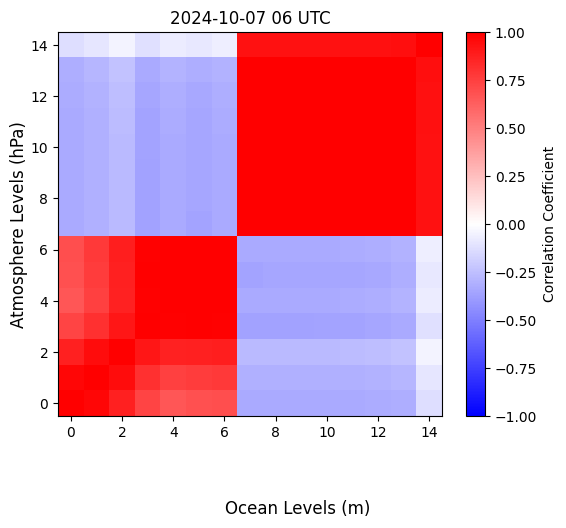

In [73]:
corTime = list(cors.keys())[0]

corFig = plt.figure(figsize=(6,6))
corAx = corFig.add_axes([0.1, 0.1, 0.8, 0.8])
corMap = corAx.imshow(cors[corTime], cmap="bwr", vmin=-1, vmax=1)
corAx.invert_yaxis()

#corAx.set_xticks(levs)
#corAx.set_yticks(levs)
#corAx.set_xticklabels(levs)
#corAx.set_yticklabels(levs)

corAx.set_title(init.strftime("%Y-%m-%d %H UTC"))
#if init != sixHours[-1]: corAx.set_xticklabels([])
#yCorner -= 0.8/len(sixHours)

plt.colorbar(corMap, label="Correlation Coefficient", shrink=0.8)
corFig.supxlabel("Ocean Levels (m)")
corFig.supylabel("Atmosphere Levels (hPa)")

if var=="T" and potentialTemp: plt.savefig(f"{var}{var}correlations{figureSuffix}_PT.png")
else: plt.savefig(f"{var}{var}correlations{figureSuffix}.png")
plt.show()

Correlations over time. Uses a given atmospheric and ocean layer (currently arbitrary) and plots correlation between them with each model run.

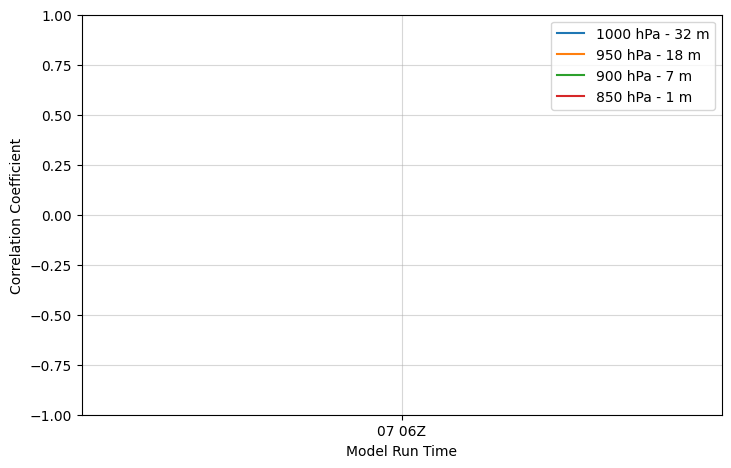

In [72]:
corTsFig = plt.figure(figsize=(8, 5))
corTsAx = corTsFig.add_axes([0.1, 0.1, 0.8, 0.8])

atmLevels = [1000, 950, 900, 850]
for lev in atmLevels:

  levIdx = list(atmLevs).index(lev) #Using for both atmosphere and ocean
  levLabel = f"{int(atmLevs[levIdx])} hPa - {int(oceLevs[levIdx])} m"

  timeCor = [cors[runtime][levIdx][levIdx] for runtime in cors.keys()]
  corTsAx.plot(list(cors.keys()), timeCor, label=levLabel)

corTsAx.grid(alpha=0.5)
corTsAx.set_xticks(list(cors.keys()))
corTsAx.set_xticklabels([key.strftime("%d %HZ") for key in list(cors.keys())])
corTsAx.set_xlabel("Model Run Time")

corTsAx.set_ylim(-1, 1)
corTsAx.set_ylabel("Correlation Coefficient")
corTsAx.legend()
plt.savefig(f"{var}corWithTime_{figureSuffix}.png")